# Implementation Convolutional Bayesian Denoising Autoencoder Alzheimer MRI Scan Dataset


## Data loading and processing

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
def plot_mnist_emnist(mnist_dataset, emnist_dataset):
    # Prepare to plot 4 rows of 6 images
    fig, axes = plt.subplots(4, 6, figsize=(12, 8))
    axes = axes.flatten()

    # Plot MNIST images
    for i in range(18):  # First 3 rows (MNIST)
        image, label = mnist_dataset[i]
        image = image.squeeze().numpy()  # Convert tensor to numpy array and remove single-dimensional entries
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')

    # Plot EMNIST images
    for j in range(18, 24):  # Last row (EMNIST)
        idx = j - 18  # Adjusted index for EMNIST images
        image, label = emnist_dataset[idx]
        image = image.squeeze().numpy()  # Convert tensor to numpy array and remove single-dimensional entries
        axes[j].imshow(image, cmap='gray')
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

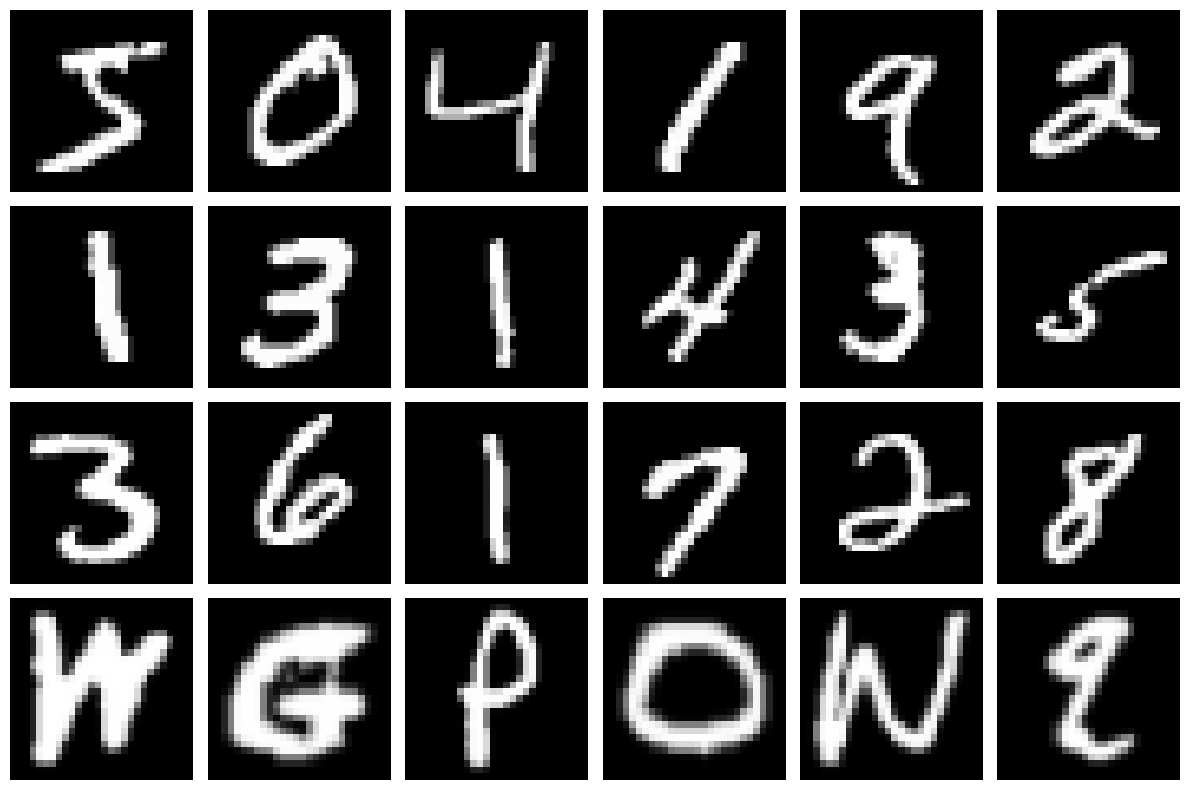

In [6]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

mnist_dataset = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True, download=True, transform=transform)

# Load the EMNIST dataset
emnist_dataset = datasets.EMNIST(
    root='./data',
    download=True,
    split='letters',
    train=True,
    transform=transforms.Compose([
        lambda img: transforms.functional.rotate(img, -90),
        lambda img: transforms.functional.hflip(img),
        transforms.ToTensor()
    ])
)

# Call the function with the datasets
plot_mnist_emnist(mnist_dataset, emnist_dataset)

In [7]:
# Constants
image_size = 128
dataset_path = '/content/drive/MyDrive/mri_dataset'
batch_size = 64

# Custom Dataset Class
class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('.jpeg', '.jpg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L').resize((image_size, image_size))
        if self.transform:
            image = self.transform(image)
        return image, 0  # Dummy label

# Create dataset instance
xray_dataset = MRIDataset(root_dir=dataset_path, transform=transform)

In [8]:
# Plot function
def plot_dataset(dataset, num_images=18):
    fig, axes = plt.subplots(3, 6, figsize=(12, 6))
    for i, ax in enumerate(axes.flatten()):
        image, _ = dataset[i]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

100%|██████████| 26421880/26421880 [00:01<00:00, 15398193.20it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 230305.78it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4268662.15it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6332046.04it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



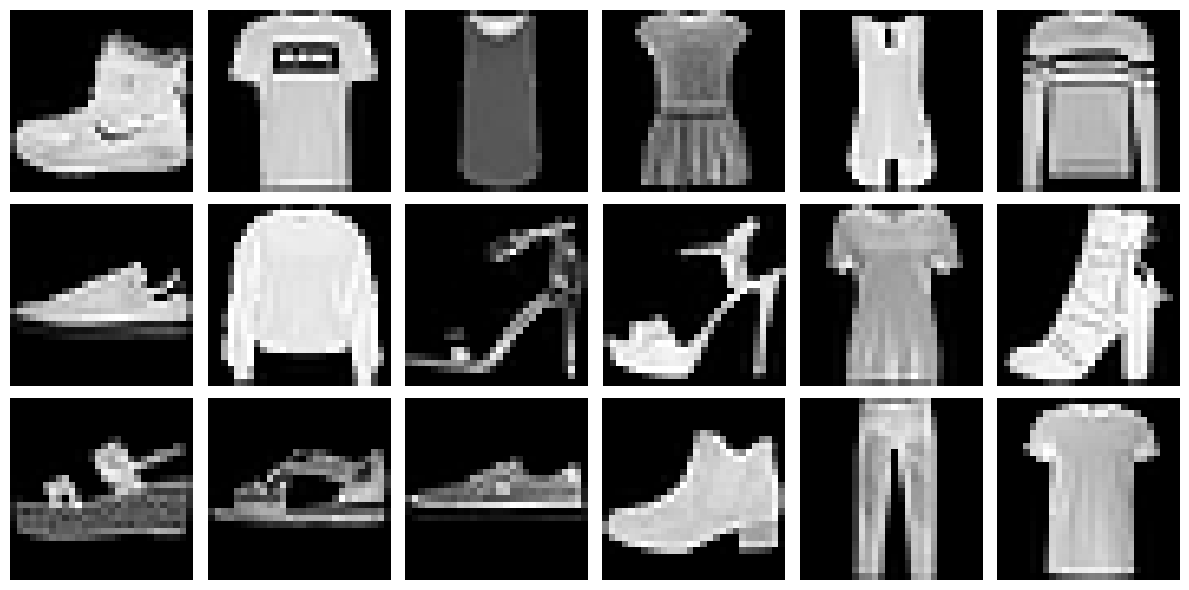

In [9]:
# load the training and test datasets
fashion_dataset = datasets.FashionMNIST(root='data', train=True,
                                      download=True, transform=transform)

plot_dataset(fashion_dataset)

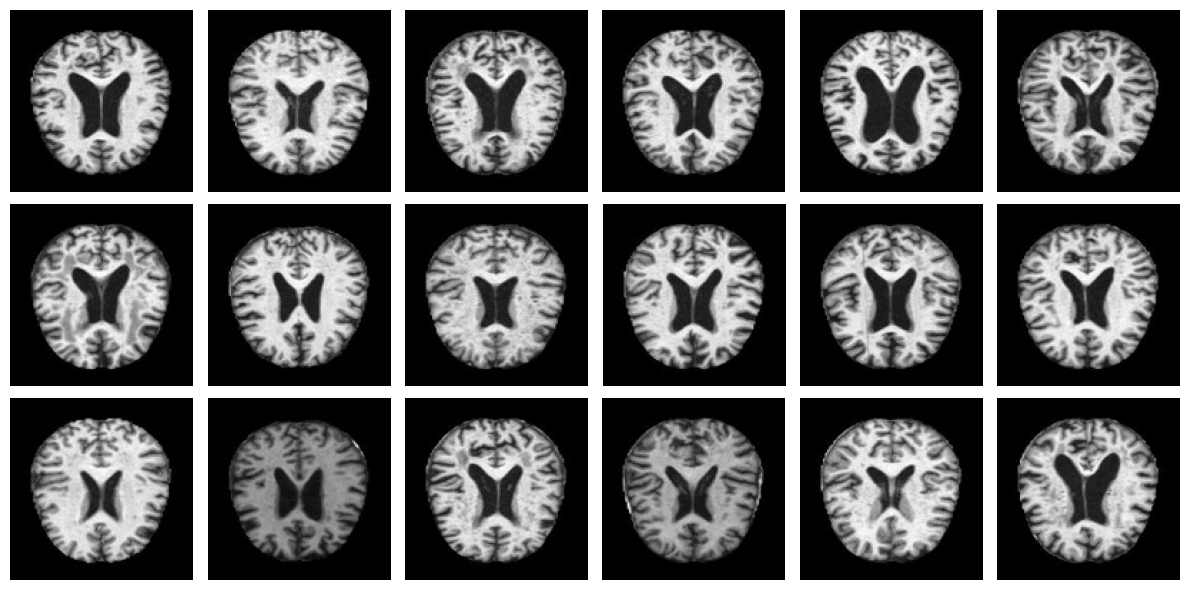

In [10]:
plot_dataset(xray_dataset)

In [11]:
def add_gaussian_noise(images, noise_factor=0.5):
  corrupted_images = images + noise_factor * torch.randn(*images.shape)
  corrupted_images = np.clip(corrupted_images, 0., 1.)
  return corrupted_images

In [12]:
def get_image_row(dataset, start_index, num_images=3):
    images = []
    for i in range(num_images):
        image, _ = dataset[start_index + i]
        images.append(image)
    return images

# Assuming you want to plot the first row of images
start_index_mnist = 0
start_index_fashion = 0
start_index_xray = 0

mnist_images = get_image_row(mnist_dataset, start_index_mnist)
fashion_images = get_image_row(fashion_dataset, start_index_fashion)
xray_images = get_image_row(xray_dataset, start_index_xray)

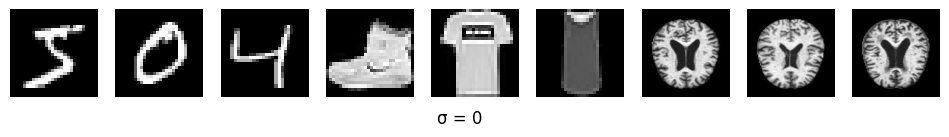

In [13]:
def plot_row(mnist_images, fashion_images, xray_images, noise_factor):
    plt.figure(figsize=(12, 4))

    # Plot MNIST images with added Gaussian noise
    for i in range(3):
        plt.subplot(1, 9, i + 1)
        noisy_image = add_gaussian_noise(mnist_images[i].view(1, 28, 28), noise_factor)
        plt.imshow(noisy_image.view(28, 28), cmap='gray')
        # plt.title('MNIST')
        plt.axis('off')

    # Plot Fashion MNIST images with added Gaussian noise
    for i in range(3):
        plt.subplot(1, 9, i + 4)
        noisy_image = add_gaussian_noise(fashion_images[i].view(1, 28, 28), noise_factor)
        plt.imshow(noisy_image.view(28, 28), cmap='gray')
        # plt.title('Fashion MNIST')
        plt.axis('off')

    # Plot X-ray images with added Gaussian noise
    for i in range(3):
        plt.subplot(1, 9, i + 7)
        noisy_image = add_gaussian_noise(xray_images[i].view(1, 128, 128), noise_factor)
        plt.imshow(noisy_image.view(128, 128), cmap='gray')
        # plt.title('X-ray')
        plt.axis('off')

    # Add caption with noise_factor value
    plt.figtext(0.5, 0.32, f"σ = {noise_factor}", ha='center', fontsize=12)

    # plt.tight_layout(pad=0.1)  # Adjust padding between plot and figure edges
    plt.show()

plot_row(mnist_images, fashion_images, xray_images, 0)

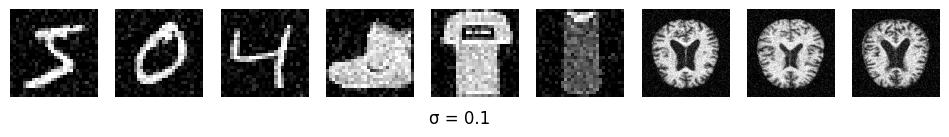

In [14]:

plot_row(mnist_images, fashion_images, xray_images, 0.1)

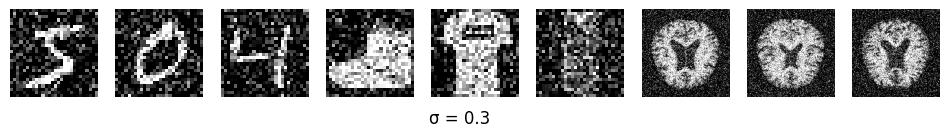

In [15]:
plot_row(mnist_images, fashion_images, xray_images, 0.3)

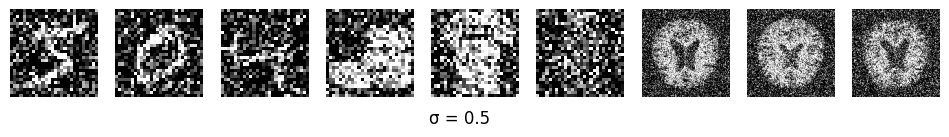

In [16]:
plot_row(mnist_images, fashion_images, xray_images, 0.5)

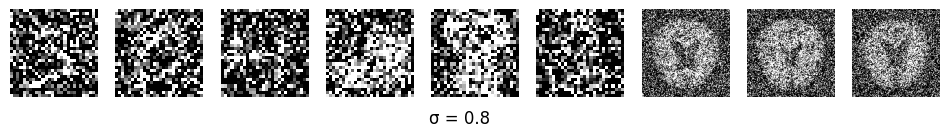

In [17]:
plot_row(mnist_images, fashion_images, xray_images, 0.8)